In [ ]:
# function ConnectButton(){
#     console.log("Connect pushed");
#     document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
# }

# var colab = setInterval(ConnectButton,3000);

# clearInterval(colab)

In [ ]:
a = []
while True:
  a.append('1')

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
import re

In [ ]:
# read data from  google Drive
!unzip '/content/drive/MyDrive/Eye_Data.zip'

Archive:  /content/drive/MyDrive/Eye_Data.zip
   creating: Eye_Data/
   creating: Eye_Data/test/
   creating: Eye_Data/test/0/
  inflating: Eye_Data/test/0/normal_100.jpg  
  inflating: Eye_Data/test/0/normal_1000.jpg  
  inflating: Eye_Data/test/0/normal_1007.jpg  
  inflating: Eye_Data/test/0/normal_1008.jpg  
  inflating: Eye_Data/test/0/normal_1013.jpg  
  inflating: Eye_Data/test/0/normal_1015.jpg  
  inflating: Eye_Data/test/0/normal_1029.jpg  
  inflating: Eye_Data/test/0/normal_1038.jpg  
  inflating: Eye_Data/test/0/normal_1040.jpg  
  inflating: Eye_Data/test/0/normal_1042.jpg  
  inflating: Eye_Data/test/0/normal_1044.jpg  
  inflating: Eye_Data/test/0/normal_1050.jpg  
  inflating: Eye_Data/test/0/normal_1056.jpg  
  inflating: Eye_Data/test/0/normal_1069.jpg  
  inflating: Eye_Data/test/0/normal_1077.jpg  
  inflating: Eye_Data/test/0/normal_1078.jpg  
  inflating: Eye_Data/test/0/normal_1094.jpg  
  inflating: Eye_Data/test/0/normal_1112.jpg  
  inflating: Eye_Data/test/0

## **Preprocessing data set**

In [ ]:
# this function collect label from directory name
def label_maker(path):
  return re.split('[/._\\\]', path)[-3]

# this function resize and read pictures from path
def imread(path):
    ans = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    ans = cv2.resize(ans, (512,512), interpolation = cv2.INTER_AREA)
    return ans


In [ ]:
# read dataset paths from directory
path_train = glob('/content/Eye_Data/train/*/*')
path_test = glob('/content/Eye_Data/test/*/*')
DF_train = pd.DataFrame(path_train, columns=['train path'])
DF_test = pd.DataFrame(path_test, columns=['test path'])

In [ ]:
# create y test & train
train_label = DF_train['train path'].map(label_maker)
test_label = DF_test['test path'].map(label_maker)

y_train = np.array(pd.get_dummies(pd.DataFrame(train_label))).astype(np.int8)
y_test = np.array(pd.get_dummies(pd.DataFrame(test_label))).astype(np.int8)

In [ ]:
# create x train & test
x_train = np.array((list)(DF_train['train path'].map(imread)))
x_test= np.array((list)(DF_test['test path'].map(imread)))

In [ ]:
# shuffle data
shuffle_index = np.random.permutation(2483)
x_train = x_train[shuffle_index]
y_train = y_train[shuffle_index]

shuffle_index = np.random.permutation(439)
x_test = x_test[shuffle_index]
y_test = y_test[shuffle_index]

In [ ]:
# normalize x
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [ ]:
# check x y train & test
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(x_train.dtype, y_train.dtype, x_test.dtype, y_test.dtype)
print(type(x_train), type(y_train), type(x_test), type(y_test))
print(x_train.min(), y_train.min(), x_test.min(), y_test.min())
print(x_train.max(), y_train.max(), x_test.max(), y_test.max())


(2483, 512, 512, 3) (2483, 2) (439, 512, 512, 3) (439, 2)
float32 int8 float32 int8
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
0.0 0 0.0 0
1.0 1 1.0 1


(<matplotlib.image.AxesImage at 0x7dac9ac13a90>, array([0, 1], dtype=int8))

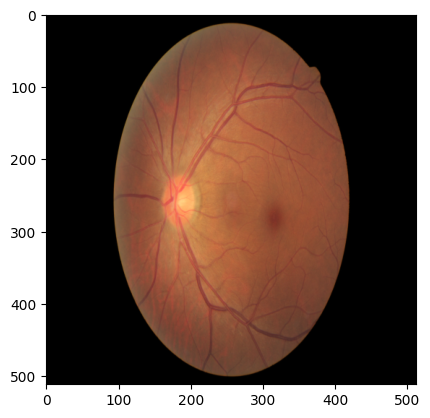

In [ ]:
i = 359
plt.imshow(x_train[i]), y_train[i]

(<matplotlib.image.AxesImage at 0x7dac45c5d900>, array([1, 0], dtype=int8))

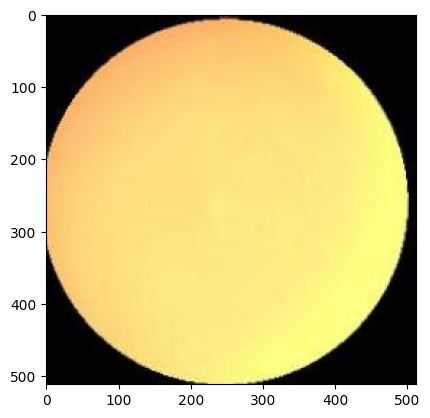

In [ ]:
i = 358
plt.imshow(x_train[i]), y_train[i]

## Create DL Model and **Train**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten, GlobalAveragePooling2D, ReLU, BatchNormalization, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import max_norm

In [ ]:

i = Input(shape=(512,512,3), batch_size=None)
x = Conv2D(filters=256, kernel_size=(10,10), activation='relu', name='block1_conv1',
           strides=(1,1), padding='valid', kernel_initializer='glorot_uniform',
           kernel_regularizer=regularizers.L1(0.01), kernel_constraint=max_norm(2.))(i)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2), strides=2)(x)

x = Conv2D(filters=512, kernel_size=(5,5))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=2)(x)
x = Conv2D(filters=1024, kernel_size=(5,5))(x)
x = Conv2D(filters=2048, kernel_size=(5,5))(x)
x = MaxPool2D(pool_size=(2,2), strides=2)(x)

GlobalAveragePooling2D()(x)
x = Dense(units=2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(units=1024, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(units=16, activation='relu')(x)
x = Dropout(0.25)(x)

prediction = Dense(units=2, activation='sigmoid')(x)

model = Model(i, prediction)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 503, 503, 256)     77056     
                                                                 
 batch_normalization (BatchN  (None, 503, 503, 256)    1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 251, 251, 256)    0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 247, 247, 512)     3277312   
                                                                 
 batch_normalization_1 (Batc  (None, 247, 247, 512)    2048  

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=x_train, y=y_train, epochs=32, batch_size=32, validation_data=(x_test, y_test))